# Deep Learning Project 2

Install and import required libraries

Try lora=alpha=16 
94.37% 84.1% 

In [20]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

In [21]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

## Load Tokenizer and Preprocess Data

In [22]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

In [23]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [24]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [25]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [26]:
!pip install peft accelerate transformers datasets

*rank=alpha=16* is the **change** here

In [27]:
from peft import get_peft_model, LoraConfig, TaskType

# Configure LoRA
lora_config = LoraConfig(
    r=16,  # rank
    lora_alpha=16, # trying alpha = rank
    target_modules=["query", "value"],  
    lora_dropout=0.1, # bumping up dropout
    bias="none",
    task_type=TaskType.SEQ_CLS  
)

# Wrap the model with PEFT
model = get_peft_model(model, lora_config)
model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [28]:
peft_model = get_peft_model(model, lora_config)
peft_model

/usr/local/lib/python3.11/dist-packages/peft/mapping.py:185: UserWarning: The PEFT config's `base_model_name_or_path` was renamed from 'roberta-base' to 'None'. Please ensure that the correct base model is loaded when loading this checkpoint.
  warnings.warn(


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): PeftModelForSequenceClassification(
      (base_model): LoraModel(
        (model): RobertaForSequenceClassification(
          (roberta): RobertaModel(
            (embeddings): RobertaEmbeddings(
              (word_embeddings): Embedding(50265, 768, padding_idx=1)
              (position_embeddings): Embedding(514, 768, padding_idx=1)
              (token_type_embeddings): Embedding(1, 768)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (encoder): RobertaEncoder(
              (layer): ModuleList(
                (0-11): 12 x RobertaLayer(
                  (attention): RobertaAttention(
                    (self): RobertaSdpaSelfAttention(
                      (query): lora.Linear(
                        (base_layer): Linear(in_features=768, out_features=768, bias=True)
                      

In [29]:
print("Trainable parameters:")
count = 0
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        count=count+1
        print(name)
print(count)

Trainable parameters:
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.value.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.0.attention.self.value.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.query.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.value.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.1.attention.self.value.lora_B.default.weight
base_model.model.base_model.model.roberta.encoder.layer.2.attention.self.query.lora_A.default.weight
base_model.model.base_model.model.roberta.encoder.layer.2.attention.s

In [30]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 1,183,492 || all params: 125,832,200 || trainable%: 0.9405


## Training Setup

In [31]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="macro")

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [32]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./roberta-lora-agnews-v2",
    per_device_train_batch_size=16,          
    per_device_eval_batch_size=16, # reducing to 16 to improve generalization
    num_train_epochs=3,                    
    learning_rate=2e-4, # significant increase                    
    logging_dir="./logs",
    logging_steps=50,
    eval_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none"
)

### Start Training

In [33]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        # Remove the unused argument before forwarding
        if "num_items_in_batch" in inputs:
            inputs.pop("num_items_in_batch")
        return super().compute_loss(model, inputs, return_outputs)

**Introducing weighted crossentropy loss**

In [34]:
import torch
import numpy as np
from collections import Counter

def get_class_weights(labels, num_classes):
    counts = Counter(labels)
    total = sum(counts.values())

    # Inverse frequency: total / (count * num_classes)
    weights = [total / (counts[i] * num_classes) for i in range(num_classes)]
    return torch.tensor(weights, dtype=torch.float)

In [35]:
from transformers import Trainer

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [36]:
train_labels = train_dataset["labels"]
class_weights = get_class_weights(train_labels, num_classes=4)

In [37]:
trainer = WeightedLossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights 
)

/tmp/ipykernel_31/1432702970.py:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [38]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.089600,0.336253,0.892188,0.892099,0.892683,0.892314
100,0.370700,0.361911,0.885938,0.895353,0.881820,0.885754
150,0.331300,0.328763,0.904687,0.909148,0.903941,0.904651
200,0.282300,0.329962,0.907813,0.911074,0.907591,0.907617
250,0.282700,0.324891,0.909375,0.913366,0.907393,0.908720
300,0.264800,0.309463,0.901563,0.901418,0.902211,0.901500
350,0.280300,0.280906,0.906250,0.906732,0.905410,0.905918
400,0.284800,0.300711,0.903125,0.902346,0.903518,0.902821
450,0.265000,0.296893,0.903125,0.907571,0.900490,0.902818
500,0.248300,0.298492,0.901563,0.901907,0.900194,0.900903


TrainOutput(global_step=11190, training_loss=0.19332844552661393, metrics={'train_runtime': 11363.3259, 'train_samples_per_second': 31.512, 'train_steps_per_second': 0.985, 'total_flos': 6.332856561772032e+16, 'train_loss': 0.19332844552661393, 'epoch': 3.0})

**Training Plots**

In [39]:
logs = trainer.state.log_history

In [86]:
import pandas as pd

log_df = pd.DataFrame(logs)
log_df = log_df[log_df["step"].notnull()]  # keep rows that are tied to steps
log_df.reset_index(drop=True, inplace=True)
log_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.0896,1.095444,0.000199,0.013405,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.013405,50,0.336253,0.892188,0.892099,0.892683,0.892314,7.3049,87.613,2.738,NaN,NaN,NaN,NaN,NaN
2,0.3707,2.043315,0.000198,0.026810,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.026810,100,0.361911,0.885938,0.895353,0.881820,0.885754,8.0881,79.128,2.473,NaN,NaN,NaN,NaN,NaN
4,0.3313,1.781305,0.000197,0.040214,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
trainer.state.best_model_checkpoint

In [82]:
log_df = pd.DataFrame(trainer.state.log_history)
best_step = log_df.loc[log_df["eval_accuracy"].idxmax(), "step"]
best_metric = log_df["eval_accuracy"].max()

print(f"Best model was at step {best_step} with accuracy {best_metric:.4f}")

Best model was at step 0 with accuracy 0.9344


In [83]:
best_checkpoint = f"./roberta-lora-agnews-v5/checkpoint-{best_step}"
if os.path.exists(best_checkpoint):
    print(f"Checkpoint exists: {best_checkpoint}")
else:
    print(f"Checkpoint not found — might need to reduce save_steps next time.")


Checkpoint not found — might need to reduce save_steps next time.


In [77]:
import pandas as pd

log_df = pd.DataFrame(trainer.state.log_history)

# ✅ Filter rows that have actual eval_accuracy (i.e., only evaluation steps)
eval_df = log_df[log_df["eval_accuracy"].notnull() & log_df["step"].notnull()]
eval_df = eval_df.drop_duplicates(subset="step", keep="last")

# Check if more than one entry exists
if len(eval_df) < 2:
    print("⚠️ Only one evaluation step was logged. Try reducing `eval_steps` or training longer.")
else:
    top_10 = eval_df.sort_values("eval_accuracy", ascending=False).head(10)
    print("🔝 Top 10 Evaluation Steps by Accuracy:")
    for i, row in top_10.iterrows():
        print(f"🔹 Step {int(row['step'])} → Accuracy: {row['eval_accuracy']:.4f}")


⚠️ Only one evaluation step was logged. Try reducing `eval_steps` or training longer.


In [87]:
log_df.head(10)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.0896,1.095444,0.000199,0.013405,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.013405,50,0.336253,0.892188,0.892099,0.892683,0.892314,7.3049,87.613,2.738,NaN,NaN,NaN,NaN,NaN
2,0.3707,2.043315,0.000198,0.026810,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.026810,100,0.361911,0.885938,0.895353,0.881820,0.885754,8.0881,79.128,2.473,NaN,NaN,NaN,NaN,NaN
4,0.3313,1.781305,0.000197,0.040214,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.040214,150,0.328763,0.904687,0.909148,0.903941,0.904651,7.3624,86.928,2.716,NaN,NaN,NaN,NaN,NaN
6,0.2823,1.909346,0.000196,0.053619,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,0.053619,200,0.329962,0.907813,0.911074,0.907591,0.907617,7.7472,82.611,2.582,NaN,NaN,NaN,NaN,NaN
8,0.2827,2.839763,0.000196,0.067024,250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,0.067024,250,0.324891,0.909375,0.913366,0.907393,0.908720,7.4455,85.958,2.686,NaN,NaN,NaN,NaN,NaN


In [89]:
# Step 1: Keep only rows where eval_accuracy is not null
eval_df = log_df[log_df["eval_accuracy"].notnull()].copy()

# Step 2: Drop duplicates (some steps might be logged more than once)
eval_df = eval_df.drop_duplicates(subset="step", keep="last")

# Step 3: Sort and take top 10
top_10 = eval_df.sort_values("eval_accuracy", ascending=False).head(100)

# Display nicely
print("🔝 Top 10 Evaluation Steps by Accuracy:")
for i, row in top_10.iterrows():
    print(f"🔹 Step {int(row['step'])} → Accuracy: {row['eval_accuracy']:.4f}")

# Optional: Save it
top_10.to_csv("top10_eval_accuracy.csv", index=False)


🔝 Top 10 Evaluation Steps by Accuracy:
🔹 Step 9900 → Accuracy: 0.9437
🔹 Step 10400 → Accuracy: 0.9422
🔹 Step 6750 → Accuracy: 0.9422
🔹 Step 8450 → Accuracy: 0.9422
🔹 Step 7000 → Accuracy: 0.9422
🔹 Step 9300 → Accuracy: 0.9422
🔹 Step 9700 → Accuracy: 0.9422
🔹 Step 9800 → Accuracy: 0.9422
🔹 Step 6050 → Accuracy: 0.9406
🔹 Step 8650 → Accuracy: 0.9406
🔹 Step 7950 → Accuracy: 0.9406
🔹 Step 7450 → Accuracy: 0.9406
🔹 Step 8200 → Accuracy: 0.9406
🔹 Step 9750 → Accuracy: 0.9406
🔹 Step 9850 → Accuracy: 0.9406
🔹 Step 9650 → Accuracy: 0.9406
🔹 Step 4800 → Accuracy: 0.9406
🔹 Step 9450 → Accuracy: 0.9406
🔹 Step 9250 → Accuracy: 0.9406
🔹 Step 7050 → Accuracy: 0.9406
🔹 Step 4600 → Accuracy: 0.9391
🔹 Step 10650 → Accuracy: 0.9391
🔹 Step 10050 → Accuracy: 0.9391
🔹 Step 7300 → Accuracy: 0.9391
🔹 Step 7350 → Accuracy: 0.9391
🔹 Step 9200 → Accuracy: 0.9391
🔹 Step 9100 → Accuracy: 0.9391
🔹 Step 9050 → Accuracy: 0.9391
🔹 Step 7700 → Accuracy: 0.9391
🔹 Step 4250 → Accuracy: 0.9391
🔹 Step 4750 → Accuracy: 0.93

In [68]:
import os
import torch
import pandas as pd
from tqdm import tqdm
from transformers import Trainer, AutoModelForSequenceClassification
from peft import PeftModel, PeftConfig

# 🔧 Adjust these paths to match your project
checkpoints_dir = "./roberta-lora-agnews-v2"

# 📦 Load your compute_metrics and training_args as defined earlier
# from your existing notebook/code context

# ✅ Load a LoRA checkpoint correctly using PEFT
def load_peft_checkpoint(path, num_labels=4):
    config = PeftConfig.from_pretrained(path)
    base_model = AutoModelForSequenceClassification.from_pretrained(
        config.base_model_name_or_path, num_labels=num_labels
    )
    model = PeftModel.from_pretrained(base_model, path)
    return model

# 📂 Find all checkpoint paths
checkpoint_paths = sorted([
    os.path.join(checkpoints_dir, d)
    for d in os.listdir(checkpoints_dir)
    if d.startswith("checkpoint-")
])

results = []

# 🔁 Evaluate all checkpoints
for path in tqdm(checkpoint_paths):
    try:
        model = load_peft_checkpoint(path, num_labels=4)
        model.to("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()

        # Reuse Trainer for evaluation
        trainer = Trainer(
            model=model,
            args=training_args,
            eval_dataset=eval_dataset,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics
        )

        eval_result = trainer.evaluate()
        results.append({
            "checkpoint": path,
            **eval_result
        })

    except Exception as e:
        print(f"❌ Failed to evaluate {path}: {e}")

# 📊 Save results to CSV and print best checkpoint
df = pd.DataFrame(results)
df_sorted = df.sort_values("eval_accuracy", ascending=False)

print("🔝 Best checkpoint based on eval_accuracy:")
print(df_sorted.head(1))

df_sorted.to_csv("checkpoint_eval_summary.csv", index=False)


  0%|          | 0/23 [00:00<?, ?it/s]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all in

  4%|▍         | 1/23 [00:08<03:00,  8.18s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

  9%|▊         | 2/23 [00:17<03:06,  8.86s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 13%|█▎        | 3/23 [00:26<02:57,  8.85s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 17%|█▋        | 4/23 [00:34<02:42,  8.53s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 22%|██▏       | 5/23 [00:42<02:28,  8.25s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 26%|██▌       | 6/23 [00:49<02:16,  8.04s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 30%|███       | 7/23 [00:57<02:05,  7.87s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 35%|███▍      | 8/23 [01:04<01:56,  7.76s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 39%|███▉      | 9/23 [01:12<01:47,  7.71s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, bu

 43%|████▎     | 10/23 [01:20<01:41,  7.81s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 48%|████▊     | 11/23 [01:28<01:33,  7.83s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 52%|█████▏    | 12/23 [01:36<01:26,  7.88s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 57%|█████▋    | 13/23 [01:44<01:19,  7.91s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 61%|██████    | 14/23 [01:52<01:11,  7.90s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 65%|██████▌   | 15/23 [02:00<01:02,  7.87s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 70%|██████▉   | 16/23 [02:08<00:55,  7.95s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 74%|███████▍  | 17/23 [02:15<00:47,  7.88s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 78%|███████▊  | 18/23 [02:23<00:39,  7.89s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 83%|████████▎ | 19/23 [02:31<00:31,  7.95s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 87%|████████▋ | 20/23 [02:39<00:23,  7.90s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 91%|█████████▏| 21/23 [02:47<00:15,  7.97s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

 96%|█████████▌| 22/23 [02:55<00:07,  7.92s/it]Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_31/1723119895.py:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, b

100%|██████████| 23/23 [03:03<00:00,  7.97s/it]

🔝 Best checkpoint based on eval_accuracy:
                                  checkpoint  eval_loss  eval_accuracy  \
17  ./roberta-lora-agnews-v2/checkpoint-7000   0.196115       0.942187   

    eval_precision  eval_recall   eval_f1  eval_runtime  \
17        0.944065     0.942323  0.943098        7.3264   

    eval_samples_per_second  eval_steps_per_second  
17                   87.356                   2.73  


In [69]:
best_model = load_peft_checkpoint("./roberta-lora-agnews-v2/checkpoint-7000")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipykernel_31/3760744267.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  log_df["train_loss"] = log_df["loss"].fillna(method="ffill")


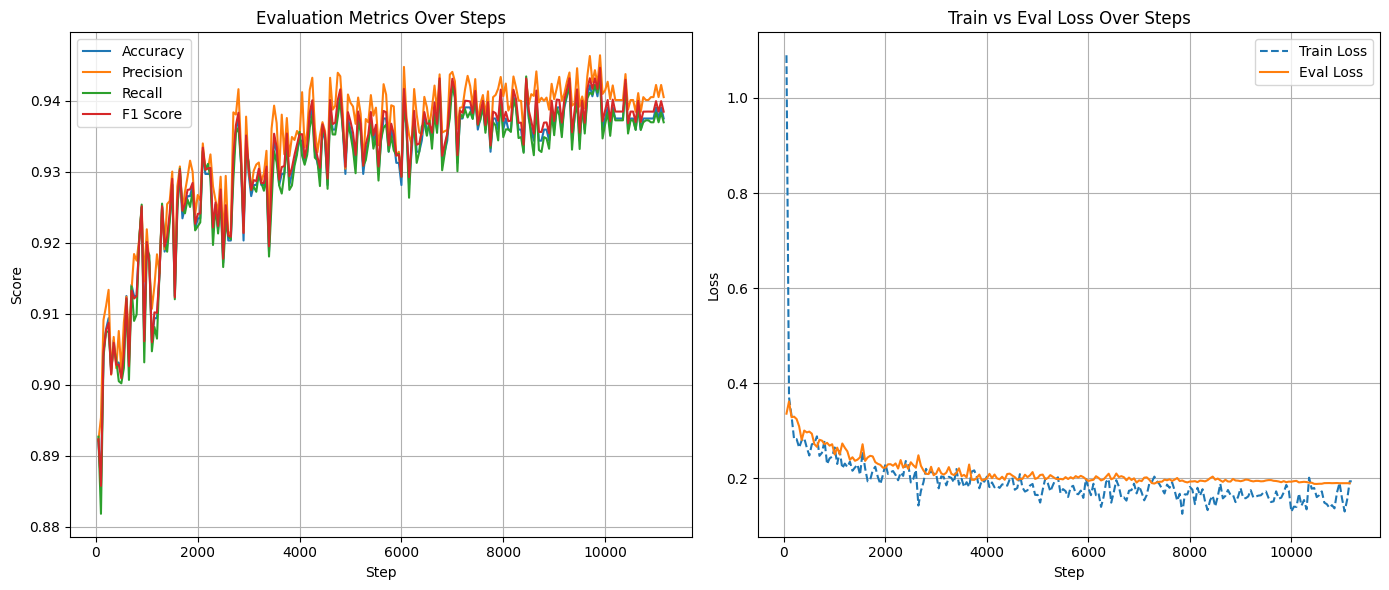

In [58]:
import matplotlib.pyplot as plt

# Clean the DataFrame: remove rows without step
log_df = log_df[log_df["step"].notnull()]
log_df = log_df.reset_index(drop=True)

# Fill train loss forward (every other row has it missing)
log_df["train_loss"] = log_df["loss"].fillna(method="ffill")

# Filter to rows with evaluation metrics
eval_df = log_df[log_df["eval_accuracy"].notnull()]

# Plotting
def plot_metrics_from_csv(log_df, eval_df):
    plt.figure(figsize=(14, 6))

    # Evaluation Metrics
    plt.subplot(1, 2, 1)
    plt.plot(eval_df["step"], eval_df["eval_accuracy"], label="Accuracy")
    plt.plot(eval_df["step"], eval_df["eval_precision"], label="Precision")
    plt.plot(eval_df["step"], eval_df["eval_recall"], label="Recall")
    plt.plot(eval_df["step"], eval_df["eval_f1"], label="F1 Score")
    plt.xlabel("Step")
    plt.ylabel("Score")
    plt.title("Evaluation Metrics Over Steps")
    plt.legend()
    plt.grid(True)

    # Training vs Evaluation Loss
    plt.subplot(1, 2, 2)
    plt.plot(log_df["step"], log_df["train_loss"], label="Train Loss", linestyle="--")
    plt.plot(eval_df["step"], eval_df["eval_loss"], label="Eval Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Train vs Eval Loss Over Steps")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics_from_csv(log_df, eval_df)


In [42]:
log_df.to_csv("training_metrics V5.1.csv", index=False)
print("✅ Training metrics saved to training_metrics.csv")

✅ Training metrics saved to training_metrics.csv


**Plan to later compare models**

In [43]:
import pandas as pd
log_df = pd.read_csv("training_metrics V5.1.csv")

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [44]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [45]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlinand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [46]:
!pip install evaluate

In [47]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm
import torch

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Returns:
        If labelled is True:
            - metrics (dict)
            - predictions (tensor)
            - true labels (tensor)
        Else:
            - predictions only
    """
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    all_labels = []

    if labelled:
        accuracy_metric = evaluate.load("accuracy")
        precision_metric = evaluate.load("precision")
        recall_metric = evaluate.load("recall")
        f1_metric = evaluate.load("f1")

    for batch in tqdm(eval_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)

        all_predictions.append(predictions.cpu())

        if labelled:
            labels = batch["labels"].cpu()
            all_labels.append(labels)

            accuracy_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            precision_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            recall_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())
            f1_metric.add_batch(predictions=predictions.cpu().numpy(), references=labels.numpy())

    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        all_labels = torch.cat(all_labels, dim=0)

        eval_metric = {
            "accuracy": accuracy_metric.compute(),
            "precision": precision_metric.compute(average="macro"),
            "recall": recall_metric.compute(average="macro"),
            "f1": f1_metric.compute(average="macro"),
        }

        print("Evaluation Metrics:", eval_metric)
        return eval_metric, all_predictions, all_labels
    else:
        return all_predictions

In [70]:
metrics, predictions, labels = evaluate_model(
    best_model,
    eval_dataset,
    labelled=True,
    data_collator=data_collator
)

100%|██████████| 80/80 [00:12<00:00,  6.19it/s]

Evaluation Metrics: {'accuracy': {'accuracy': 0.9421875}, 'precision': {'precision': 0.9440646622804404}, 'recall': {'recall': 0.9423231771121141}, 'f1': {'f1': 0.9430980110508951}}


In [90]:
from sklearn.metrics import classification_report

class_names = dataset.features["label"].names

print("\nPer-Class Metrics:\n")
print(classification_report(labels.numpy(), predictions.numpy(), target_names=class_names))


Per-Class Metrics:

              precision    recall  f1-score   support

       World       0.94      0.93      0.94       145
      Sports       0.98      0.99      0.98       158
    Business       0.95      0.92      0.93       153
    Sci/Tech       0.90      0.93      0.92       184

    accuracy                           0.94       640
   macro avg       0.94      0.94      0.94       640
weighted avg       0.94      0.94      0.94       640



In [50]:
import matplotlib.pyplot as plt

def plot_per_class_f1(preds, labels, class_names):
    report = classification_report(
        labels.numpy(),
        preds.numpy(),
        target_names=class_names,
        output_dict=True
    )
    f1_scores = {cls: report[cls]["f1-score"] for cls in class_names}

    plt.figure(figsize=(10, 5))
    plt.bar(f1_scores.keys(), f1_scores.values())
    plt.ylim(0, 1)
    plt.ylabel("F1 Score")
    plt.title("Per-Class F1 Scores")
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

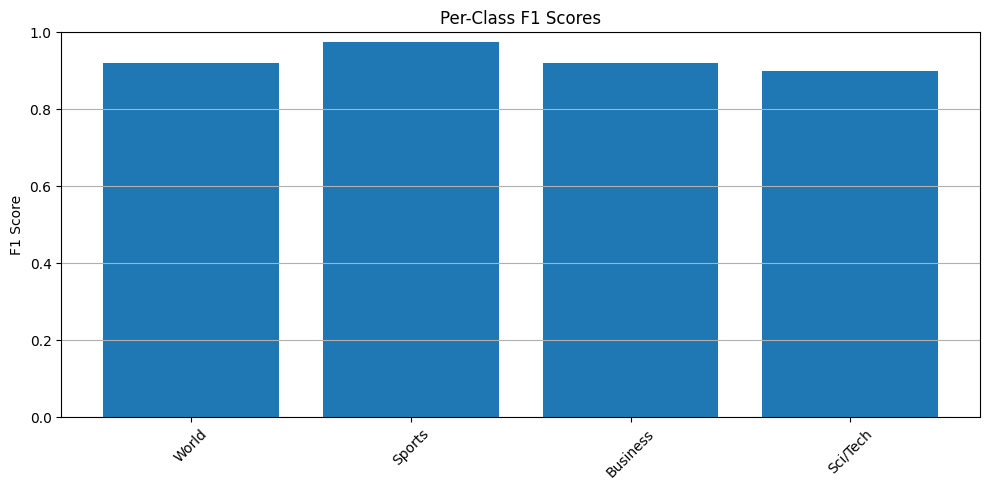

In [51]:
plot_per_class_f1(predictions, labels, class_names)

In [52]:
!pip install scikit-learn matplotlib seaborn

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(predictions, labels, class_names):
    cm = confusion_matrix(labels, predictions)

    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45)

    ax.set_yticks(range(len(class_names)))
    ax.set_yticklabels(class_names, rotation=0)

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

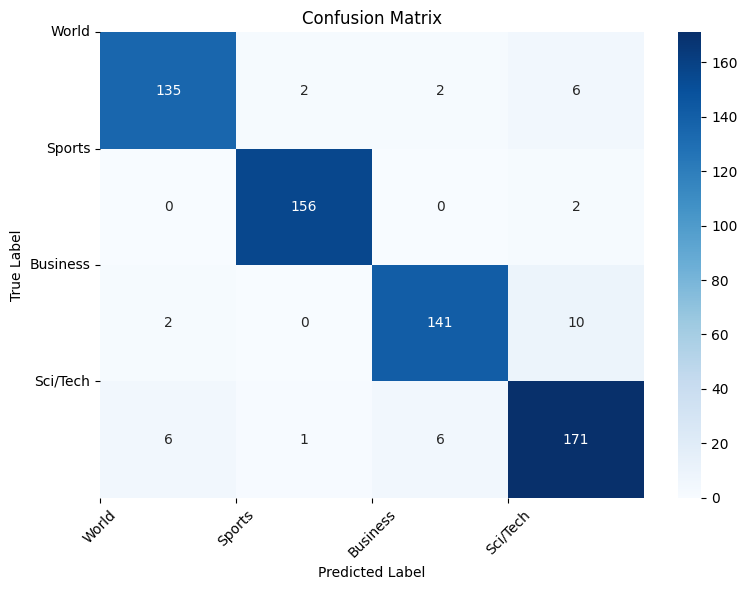

In [72]:
plot_confusion_matrix(predictions.numpy(), labels.numpy(), class_names)

In [55]:
import pandas as pd
df = pd.DataFrame({"predictions": predictions, "labels": labels})
df.to_csv("confusion_data.csv", index=False)

### Run Inference on unlabelled dataset

In [56]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [74]:
# Run inference and save predictions
preds = evaluate_model(best_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})

df_output.to_csv('/kaggle/working/submission_bestEval.csv', index=False)
print("Inference complete. Predictions saved to submission.csv")

100%|██████████| 1000/1000 [01:58<00:00,  8.41it/s]

Inference complete. Predictions saved to submission.csv
